## Image analysis of decor confetti

This notebook demonstrates the analysis of the color distribution of decor confetti. It was designed to answer the question "Do all colors occur with the same freuency?"

Import of the libraries used fo analysis.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.mixture import GaussianMixture
from scipy.stats import chisquare

### Image preparation

The image was read using <code>opencv</code>. The default color order is <code>BGR</code>. The image is converted into an <code>RGB</code> image for display with <code>matplotlib</code> as well as a gray scale image and an <code>HLS</code> image for analysis.

In [2]:
# read image and convert into different formats
bgr = cv2.imread('IMG_1147.jpeg')
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
hls = cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) # for display
m, n = gray.shape

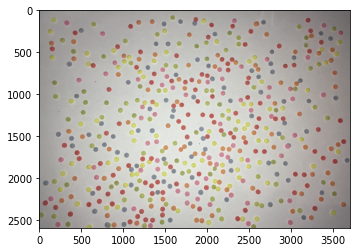

In [3]:
# display the image using matplotlib
plt.imshow(rgb)
plt.show()

The image is not well illuminated. However, this will be no problem later.

### Circle detection

Detection of circles is performed on the gray scale image. First, the image is blurred using a Gassian filter to avoid artifacts during edge detection (and therefore circle detection).
Then, a circle Hough Transform is applied to detect the circles (see https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/hough_circle/hough_circle.html and https://en.wikipedia.org/wiki/Circle_Hough_Transform). The parameters to the circle Hough Transform were determined empirically.

In [4]:
# blurr image to avoid artifacts
blurred = cv2.GaussianBlur(gray, (9, 9), 2, 2)
# perform a Hough transform to detect circles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, 20,
    param1=35,param2=25,minRadius=20,maxRadius=50)
# convert anything to integers
circles = np.round(circles[0, :]).astype("int")
print(f"Found {len(circles)} circles!")

Found 526 circles!


These circles can then be projected onto the gray image to check for the success of the circle detection.

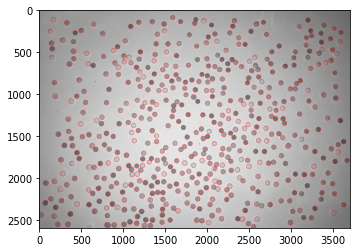

In [5]:
output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
for x, y, r in circles:
    cv2.circle(output, (x, y), r, (255, 0, 0), 2)
cv2.imwrite('circles.png', output)
plt.imshow(output)
plt.show()

Using the circle Hough Transform, 526 circles (confetti) could be identified. A visual inspection reveals neither false positives nor false negatives.

### Color identification

After successfully detecting the circles (confetti) the color of the circles can be determined. I decided on using the mean color value of square centered at the circle with the radius as side length. This simultaneously avoids noise and allows for moderate overlap of circles.

In [6]:
mean_colors = np.zeros(shape=(len(circles), 3))
for i, (x, y, r) in enumerate(circles):
    min_y = max(y - r//2, 0)
    max_y = min(y + r//2, m)
    min_x = max(x - r//2, 0)
    max_x = min(x + r//2, n)
    circle_section = rgb[min_y:max_y+1,min_x:max_x+1,:].reshape((-1, 3))
    mean_color = np.mean(circle_section, axis=0)
    mean_colors[i,:] = np.mean(circle_section, axis=0)
mean_colors = mean_colors.astype(np.uint8)

After having extracted the color of the circles, the circle colors can be plotted in <code>RGB</code> space in a 3-dimensional scatter plot.

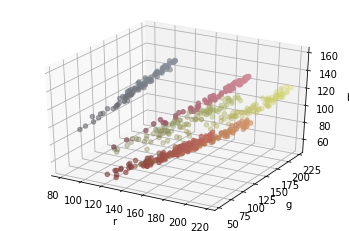

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
r, g, b = np.swapaxes(mean_colors, 0, 1)
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_zlabel('b')
ax.scatter(r, g, b, c=mean_colors / 255)
plt.show()

This plot clearly reveals that there are indeed 6 different colors - namely pink, blue, red, brown, green and yellow.
The results are quite interesting: The indidividual colors are spread over a large range, however, are clearly visually separable (and identifiable) - except for the yellow and green confetti colors. It seems that the spread is mostly due to different shades of the same color. To test for this hypothesis, the <code>HLS</code> color representation was used instead (https://en.wikipedia.org/wiki/HSL_and_HSV) that explicitly encodes the lightness.

In [8]:
mean_colors_hls = cv2.cvtColor(mean_colors.reshape((1, -1, 3)), cv2.COLOR_RGB2HLS)[0]

The HLS colors are plotted in polar coordinates. Here, the lightness dimension was removed.

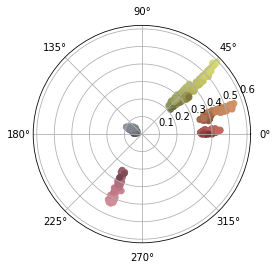

In [9]:
h, l, s = np.swapaxes(mean_colors_hls, 0, 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
theta = h / 255 * 2 * math.pi
radius = s/255
ax.scatter(theta, radius, color=mean_colors/255)
plt.show()

Here, it becomes clear that the hypothesis is correct: The different colors are well separated (except again for green and yellow) and show far less spread than in <code>RGB</code> space. Therefore, the analysis was continued in the <code>HS</code> space. The polar coordinates were converted into Euclidean space.

In [10]:
x = radius * np.cos(theta)
y = radius * np.sin(theta)
xy = np.swapaxes((x,y), 0, 1)

### Clustering of confetti

To determine the number of confetti pieces of each color the colors must be clustered. After experimenting with different clustering algorithm, a Gaussian mixture model (https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) was selected as it gave best performance. As this is a random process, a few iterations were needed to give satisfactory performance.

In [16]:
n_clusters = 6 # we know that there are six clusters (six confetti colors)
# use Gaussian mixture model
clustered = GaussianMixture(n_clusters, covariance_type='full').fit(xy)
labels = clustered.predict(xy)

label_colors = []
for label in set(labels):
    colors = mean_colors[labels == label]
    mean = np.mean(colors, axis=0)
    label_colors.append((label, mean, np.mean(h[labels == label])))
# important: the colors are sorted by the hue values H as this allows a clear identification
# of colors (except for yellow and green) and therefore the order will always be the same
label_colors.sort(key=lambda x: x[2])

These results can be plotted and marked with the corresponding clusters.

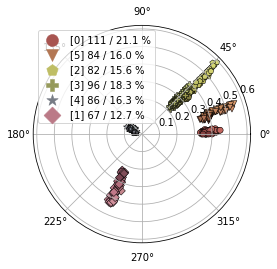

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
markers="ovpP*D"
handles = []
text_labels = []
legend_colors = []
for marker, (label, color, _) in zip(markers, label_colors):
    h_members = h[labels == label]
    s_members = s[labels == label]
    colors = mean_colors[labels == label]

    percentage = 100.0 * float(len(h_members)) / len(xy)
    mean = np.mean(colors, axis=0)
    legend_colors.append(mean / 255)
    theta = h_members / 255 * 2 * math.pi
    radius = s_members / 255
    handle = ax.scatter(theta, radius, color=colors/255, marker=marker, edgecolors='k', linewidths=0.5)

    handles.append(handle)
    text_labels.append("[{}] {} / {:.1f} %".format(label, len(h_members), percentage))

legend = ax.legend(handles, text_labels, markerscale=2.)
for i, color in enumerate(legend_colors):
    legend.legendHandles[i].set_color(color)


The Gaussian mixture model is able to separate the clusters well. Again, with the exception that yellow and green are hard to separate. The given percentages give a first hint that indeed the colors might not be equally distributed (cf. pink and red).

This was further analyzed by performing a chi-square test (https://en.wikipedia.org/wiki/Chi-squared_test) to compare the observed color frequencies against the expected frequencies. Here, the Nullhypothesis is that the observed frequencies are equal to the expected frequencies (i.e. all colors occur equally often).

To avoid a potential bias due to the badly separable green and yellow confetti, these clusters were merged. This avoids rejecting the Nullhypothesis because green and yellow confetti were not identified correctly.

In [19]:
# calculate a histogram
hist, _ = np.histogram(labels, bins=np.arange(n_clusters+1))
# calculate the expected frequencies (equally distribution)
target_frequency = [float(len(labels)) / n_clusters for _ in range(n_clusters)]

# merge the yellow and green cluster: histogram
# (yellow and green are not separable by Hue value, but from the others, i.e.
#  entries 2 and 3 are always yellow and green in any order);
# label_colors are sorted by Hue value of the cluster!
hist[label_colors[2][0]] += hist[label_colors[3][0]]
hist[label_colors[3][0]] = 0
# remove empty bin from histogram (leads to error otherwise)
hist = [v for v in hist if v != 0.0]
# merge yellow and green cluster: expected frequencies
target_frequency[label_colors[2][0]] += target_frequency[label_colors[3][0]]
target_frequency[label_colors[3][0]] = 0
target_frequency = [v for v in target_frequency if v != 0.0]

# perform chi-square test
chisq, p = chisquare(hist, target_frequency)
print(chisq, p)

11.307984790874524 0.02331227202539452


With a p-value < 0.05 we have to reject the Nullhypothesis. Therefore, the colors in the decor confetti can not be assumed to be equally distributed (even with removing the potential green-yellow bias).